In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap, grad, jacfwd
import jax.flatten_util
from time import time
import pandas as pd
import numpy as np

In [3]:

# High Speed Settings
n_x = 1000  # number of sample points in sapce
sub_sample = 150  # number of paramters to randomly sample
dt = 5e-3  # time step for rk4 integrator


# High Accuracy Settings 
# n_x = 10_000 # number of sample points in sapce
# sub_sample = 800 # number of paramters to randomly sample
# dt = 5e-3 # time step for rk4 integrator

In [4]:
# set up time and space domain
Tend = 4.0
t_eval = jnp.linspace(0.0, Tend, int(Tend/dt)+1)

dim = 1
A, B = 0, 2*jnp.pi
x_eval = jnp.expand_dims(jnp.linspace(A, B, n_x), axis=-1)

In [5]:
from rsng.dnn import build_nn, init_net

key = jax.random.PRNGKey(1)

width = 25
depth = 7
period = 2*jnp.pi

net = build_nn(width, depth, period)
u_scalar, theta_init, unravel = init_net(net, key, dim)

In [6]:
# used to take gradient and then squeeze
def gradsqz(f, *args, **kwargs):
    return lambda *fargs, **fkwargs: jnp.squeeze(grad(f, *args, **kwargs)(*fargs, **fkwargs))


# batch the function over X points
U = vmap(u_scalar, (None, 0))

# derivative with repsect to theta
U_dtheta = vmap(grad(u_scalar), (None, 0))

# spatial derivatives
U_ddx = vmap(gradsqz(gradsqz(u_scalar, 1), 1), (None, 0))

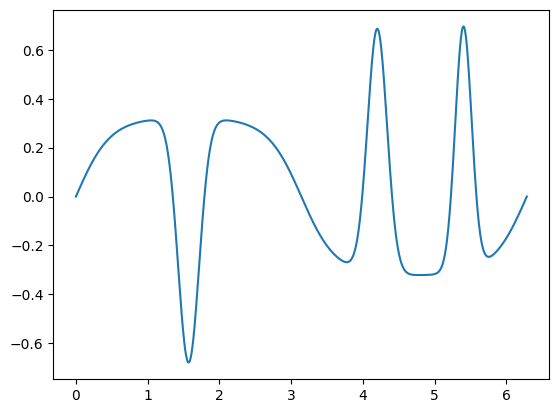

In [7]:
# load the parameters which fit inital condition
theta_0 = pd.read_pickle('./rsng/data/theta_init_ac.pkl')
theta_0 = jax.flatten_util.ravel_pytree(theta_0)[0]
# plot inital condition
plt.plot(x_eval, U(theta_0, x_eval))
plt.show()

In [8]:

def rhs(t, theta):
    "f(theta), dynamics for the allen-cahn equation"
    u = U(theta, x_eval)
    u_xx = U_ddx(theta, x_eval)
    return 5e-3*u_xx+u-u**3


def rhs_reparamaterized(t, theta, key):
    """
    we project f(theta) onto J(theta)
    we then sparsely subsample J via S_t
    finally we solve a least sqaures problem to get theta_dot
    """
    J = U_dtheta(theta, x_eval)  # take the gradient with respect to the parameters
   
    # key=jax.random.split(key)[0]
    # print(key)
    # J = jax.random.normal(key, (n_x, len(theta)))  
    # J = jnp.ones((n_x, len(theta)))
    # J= jnp.multiply(J,150)
    
    S_t = jax.random.choice(key, len(theta), shape=(sub_sample,), replace=False) # create random indices over the columns
    J = jnp.take(J, S_t, axis=1)  # subsample columns
    f = rhs(t, theta)  # compute f from rhs

    # solve least sqaures problem on subsampled gradient
    theta_dot = jnp.linalg.lstsq(J, f, rcond=1e-4)[0]
    
    # go back into full parameter space, zero for non sampled columns
    theta_dot = jnp.zeros(len(theta)).at[S_t].set(theta_dot)
    return theta_dot

In [9]:
def odeint_rk4(fn, y0, t, key):
    "Adapted from: https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/jax_cosmo/scipy/ode.py"
    def rk4(carry, t):
        y, t_prev, key = carry
        h = t - t_prev
        key, subkey = jax.random.split(key)

        k1 = fn(t_prev, y, subkey)
        k2 = fn(t_prev + h / 2, y + h * k1 / 2, subkey)
        k3 = fn(t_prev + h / 2, y + h * k2 / 2, subkey)
        k4 = fn(t, y + h * k3, subkey)

        y = y + 1.0 / 6.0 * h * (k1 + 2 * k2 + 2 * k3 + k4)
        return (y, t, key), y

    (yf, _, _), y = jax.lax.scan(rk4, (y0, jnp.array(t[0]), key), t)
    return y

In [10]:
def integrate(y0, t):
    return odeint_rk4(rhs_reparamaterized, y0, t, key)

# here we seperate compile time from integration time
integrate_complied = jit(integrate).lower(theta_0, t_eval).compile()
print('jit complied!')
time_start = time()
y = integrate_complied(theta_0, t_eval)
time_end = time()
print('done!')

jit complied!
done!


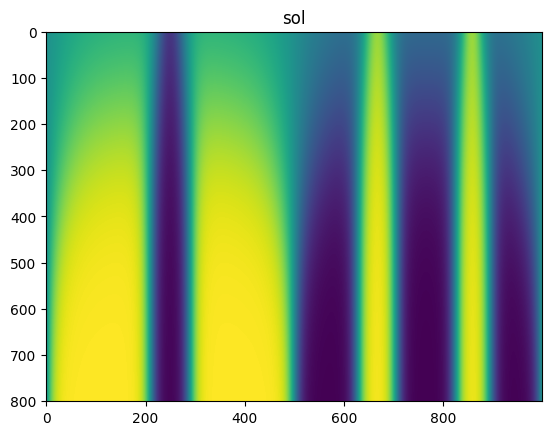

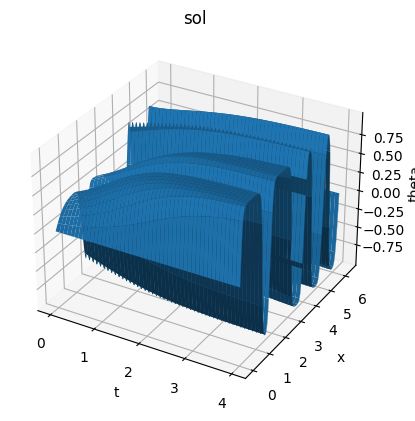

In [16]:

steps = len(t_eval)
theta_dot = np.zeros((steps, len(x_eval)))
for i in range(steps):
    theta = y[i, :]
    theta_dot[i] = jnp.squeeze(U(theta, x_eval))

plt.imshow(theta_dot, aspect='auto') 
# 
plt.title('sol')
plt.show()
# we can actually draw another 3d graph of the solution. Here is the code
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(t_eval, x_eval)

plt.title('sol')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('theta')
ax.plot_surface(X, Y, theta_dot.T)
plt.show()





In [12]:
import scipy
from scipy.interpolate import RegularGridInterpolator

# evalulate the error against the true solution

data = scipy.io.loadmat('./rsng/data/gt_ac_small.mat')
t_true = np.float32(data['t'][0])
x_true = np.float32(data['x'][0])
usol = np.float32(data['Uvals'])

gt_f = RegularGridInterpolator(
    (t_true, x_true), usol, method='linear', bounds_error=True)

m_grids = np.meshgrid(t_eval, x_eval, indexing='ij')
m_grids = [m.flatten() for m in m_grids]
t_grid = np.array(m_grids, dtype=np.float32).T
true = gt_f(t_grid).reshape(len(t_eval), len(x_eval))

In [13]:
rl = np.linalg.norm(true-theta_dot) / np.linalg.norm(true)
print(f'relative l2 error: {rl:.2e}')
print(f'Time: {time_end-time_start}')

relative l2 error: 6.74e-05
Time: 80.23546600341797
